In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [2]:
model = torch.jit.load("/home/jan/Projects/parcaster/model/wandb/run-20231129_105215-82zbhzcq/files/model_scripted.pt")
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Copied that over from testing, TODO remove it

def load_features_labels():
    df = pd.read_csv("../data/preprocessing/02_pp_sg_train_features.csv", sep=";")

    parking_data_labels = ["P24", "P44", "P42", "P33", "P23", "P25", "P21", "P31", "P53", "P32", "P22", "P52", "P51",
                           "P43"]  # TODO get these from metadata file
    ignored_columns = ["datetime", "date", "year", "month", "day", "weekdayname", "weekday", "time", "hour", "minute"]

    y = df[parking_data_labels]
    X = df.drop(columns=parking_data_labels)
    X = X.drop(columns=ignored_columns)

    input_dim = len(X.columns)
    output_dim = len(y.columns)

    print(f"Input dimension: {input_dim}, columns: {X.columns}")
    print(f"Output dimension: {output_dim}, columns: {y.columns}")

    return X, y, input_dim, output_dim


def build_dataset(batch_size, X, y):
    features = torch.Tensor(X.values)
    targets = torch.Tensor(y.values)

    dataset = TensorDataset(features, targets)

    return DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)


In [4]:
def plot_prediction(output, target):
    numpy_output = output.detach().cpu().numpy()
    numpy_target = target.detach().cpu().numpy()
    
    parking_data_labels = ["P24", "P44", "P42", "P33", "P23", "P25", "P21", "P31", "P53", "P32", "P22", "P52", "P51",
                           "P43"]  # TODO get these from metadata file
    df_output = pd.DataFrame(numpy_output, columns=parking_data_labels)
    df_target = pd.DataFrame(numpy_target, columns=parking_data_labels)

    n_features = len(df_output.columns)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Setting the positions of the bars
    ind = np.arange(n_features)  # the x locations for the groups
    width = 0.35  # the width of the bars
    
    # Plotting bars for each row
    bars1 = ax.bar(ind - width/2, df_output.iloc[0], width, label='Prediction')
    bars2 = ax.bar(ind + width/2, df_target.iloc[0], width, label='Target')
    
    # Adding some text for labels, title, and custom x-axis tick labels
    ax.set_xlabel('Features')
    ax.set_ylabel('Values')
    ax.set_title('Comparison of Two Rows in a Bar Chart')
    ax.set_xticks(ind)
    ax.set_xticklabels(df_output.columns)
    ax.legend()
    
    plt.show()

Input dimension: 18, columns: Index(['ferien', 'feiertag', 'covid_19', 'olma_offa', 'temperature_2m_max',
       'temperature_2m_min', 'rain_sum', 'snowfall_sum', 'sin_minute',
       'cos_minute', 'sin_hour', 'cos_hour', 'sin_weekday', 'cos_weekday',
       'sin_day', 'cos_day', 'sin_month', 'cos_month'],
      dtype='object')
Output dimension: 14, columns: Index(['P24', 'P44', 'P42', 'P33', 'P23', 'P25', 'P21', 'P31', 'P53', 'P32',
       'P22', 'P52', 'P51', 'P43'],
      dtype='object')


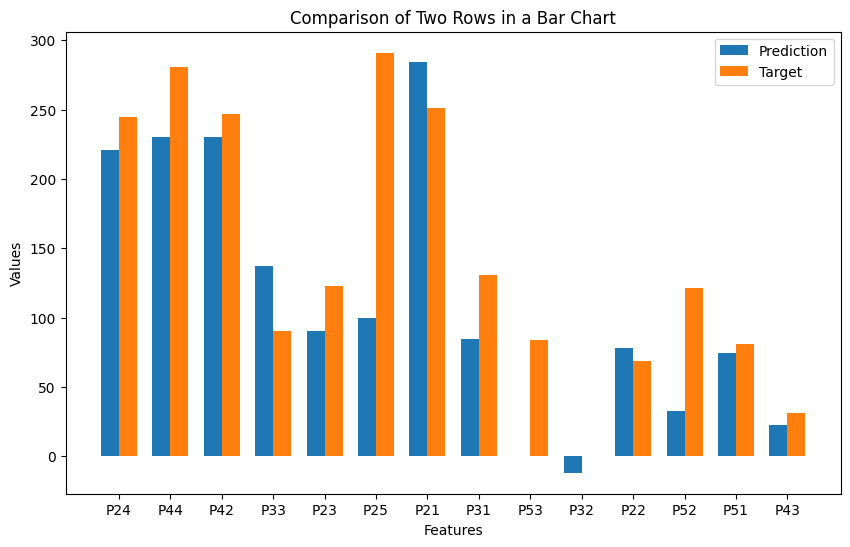

In [5]:
X, y, input_dim, output_dim = load_features_labels()

batch_size = 1
index_to_predict = 10000

X_to_predict = X[index_to_predict:index_to_predict+batch_size]
y_to_predict = y[index_to_predict:index_to_predict+batch_size]

dataloader = build_dataset(batch_size, X_to_predict, y_to_predict)

for _, (data, target) in enumerate(dataloader):
    data, target = data.view([batch_size, -1, input_dim]).to(device), target.to(device)
    output = model(data)
    plot_prediction(output, target)